In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import defaultdict
import plotly.express as px
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import json
from itertools import chain
#from rich import print
import sys
import os
import utils
import matplotlib.pyplot as plt
import seaborn as sns

# Đường dẫn đến thư mục mini_model
mini_model_path = os.path.abspath(os.path.join(os.getcwd(), ''))

# Lấy danh sách tất cả thư mục con trong mini_model
for folder in os.listdir(mini_model_path):
    folder_path = os.path.join(mini_model_path, folder)
    # Chỉ thêm nếu là thư mục và không phải file
    if os.path.isdir(folder_path):
        if folder_path not in sys.path:
            sys.path.append(folder_path)

import function_get_score_amenities as fga
import function_get_score_rate as fgr
import CF_user_review.CF_user_scores as cfus
import recommenr_review_data as rhr
import review_quality
import recommend_location as rl
import recommend_polices as rp
import recommed_room as rr
import function_get_score_price as fgsp


In [2]:
from pathlib import Path
import config as config 
DEFAULT_BASE_DIR = Path("D:/graduate_dissertation/final")

In [3]:
with open(config.get_path("feature_sub_rate.json"), 'r', encoding='utf-8') as f:
    feature_sub_rate = json.load(f)

with open(config.get_path("weights_criteria_utilities.json"), 'r', encoding='utf-8') as f:
    weights_criteria_utilities = json.load(f)

with open(config.get_path("feature_popular_facilities.json"), 'r', encoding='utf-8') as f:
    feature_popular_facilities = json.load(f)
    
with open(config.get_path("feature_facilities.json"), 'r', encoding='utf-8') as f:
    feature_facilities = json.load(f)

with open(config.get_path("feature_url.json"), 'r', encoding='utf-8') as f:
    feature_url = json.load(f)

with open(config.get_path("feature_allRoom.json"), 'r', encoding='utf-8') as f:
    feature_allRoom = json.load(f)
    
with open(config.get_path("review_processing.json"), 'r', encoding='utf-8') as f:
    result_groupby_id= json.load(f)

with open(config.get_path("feature_location.json"), 'r', encoding='utf-8') as f:
    feature_location = json.load(f)

with open(config.get_path("feature_policies.json"), 'r', encoding='utf-8') as f:
    feature_policies = json.load(f)

with open(config.get_path('hotel_data_room.json'), 'r', encoding='utf-8') as f:
    feature_detail_room = json.load(f)

with open(config.get_path('feature_star_rating.json'), 'r', encoding='utf-8') as f:
    feature_star_rating = json.load(f)


In [4]:
recommend_faclities_hotel = fga.HotelSimilarityRecommender(    
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_gpu=True,
    model_dir=DEFAULT_BASE_DIR.joinpath("mini_model\\function_get_score_amenities\\model_similarity_amenities\\hotel"),
    type='hotel',
    batch_size=256,
    faiss_metric='IP'
)
recommend_faclities_hotel.load_model()
recommend_faclities_room = fga.HotelSimilarityRecommender(
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_gpu=True,
    model_dir=DEFAULT_BASE_DIR.joinpath("mini_model\\function_get_score_amenities\\model_similarity_amenities\\room"),
    type='room',
    batch_size=256,
    faiss_metric='IP'
)
recommend_faclities_room.load_model()


Initializing Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
Using CPU for Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
SafeTensors file D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\model.safetensors not found, initializing new model
Initialized new model paraphrase-multilingual-MiniLM-L12-v2 on CPU
Loaded hotel data from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\hotel_data.pkl
Loaded vectors from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\hotel_vectors.npy
Loaded Faiss index from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\faiss_index.bin
Initializing Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
Using CPU for Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
SafeTensors file D:\graduate_dissertation\

In [5]:
CF = cfus()
state_model = CF.load_model(DEFAULT_BASE_DIR.joinpath('mini_model\\CF_user_review\\CF_state_for_user.pkl'))
country_model = CF.load_model(DEFAULT_BASE_DIR.joinpath('mini_model\\CF_user_review\\CF_country_for_user.pkl'))

In [6]:
hotel_review_stats = review_quality.HotelReviewStats()
hotel_review_stats.load_stats()

Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json


defaultdict(<function review_quality.HotelReviewStats.load_stats.<locals>.<lambda>()>,
            {'10000593': {'count_review': 446,
              'count_review_with_image': 87,
              'count_long_review': 237,
              'total_score': 4127.0,
              'num_score': 446,
              'avg_score': 9.253363228699552},
             '10000695': {'count_review': 18,
              'count_review_with_image': 0,
              'count_long_review': 3,
              'total_score': 151.0,
              'num_score': 18,
              'avg_score': 8.38888888888889},
             '10001679': {'count_review': 45,
              'count_review_with_image': 7,
              'count_long_review': 21,
              'total_score': 387.0,
              'num_score': 45,
              'avg_score': 8.6},
             '10003086': {'count_review': 36,
              'count_review_with_image': 1,
              'count_long_review': 8,
              'total_score': 308.0,
              'num_score': 36,


In [7]:
def compute_score_room_infor(hotels, rooms, weight=[0.5, 0.5]):
    # Tạo dict nhanh để tra theo (id, room_id)
    room_lookup = {
        (room['id'], room['room_id']): room['room_score']
        for room in rooms
    }

    results = []
    for hotel in hotels:
        key = (hotel['id'], hotel['room_id'])
        if key in room_lookup:
            room_score = room_lookup[key]
            score_price = hotel.get('room_score_price', 0)
            score_room_infor =  weight[0] * room_score + weight[1] * score_price
            #score_room_infor = 0.6 * room_score + 0.4 * score_price 

            results.append({
                'id': hotel['id'],
                'room_id': hotel['room_id'],
                'score_room': score_room_infor
            })

    return results


In [8]:
def combine_room_and_hotel_scores(rooms, hotel_score_list, weight=0.6):
    # Tạo dict để tra nhanh điểm hotel theo id
    hotel_score_dict = {str(hotel_id): score for hotel_id, score in hotel_score_list}

    results = []
    for room in rooms:
        hotel_id = str(room['id'])  # chuyển sang str để khớp key
        room_score = room['score_room_infor']

        if hotel_id in hotel_score_dict:
            hotel_score = hotel_score_dict[hotel_id]
            final_score = weight * room_score + (1 - weight) * hotel_score

            # Gộp lại kết quả
            results.append({
                'id': room['id'],
                'room_id': room['room_id'],
                'score_room_infor': room_score,
                'hotel_score': hotel_score,
                'final_score': final_score
            })

    return results


In [9]:
def combine_room_and_hotel_scores_with_details(
    rooms,
    hotel_score_list,
    extra_score_dicts,
    extra_score_keys,
    weight=0.6
):
    hotel_score_dict = {str(hotel_id): score for hotel_id, score in hotel_score_list}

    results = []
    for room in rooms:
        hotel_id = str(room['id'])
        room_score = room['score_room']

        if hotel_id in hotel_score_dict:
            hotel_score = hotel_score_dict[hotel_id]
            final_score = weight * room_score + (1 - weight) * hotel_score

            result = {
                'id': room['id'],
                'room_id': room['room_id'],
                'score_room': room_score,
                'hotel_score': hotel_score,
                'final_score': final_score
            }

            # Thêm các điểm đánh giá chi tiết nếu có
            for score_dict, score_key in zip(extra_score_dicts, extra_score_keys):
                result[score_key] = score_dict.get(room['id'], None)

            results.append(result)

    return results


In [10]:
query = {
    # ====== location ======
    'province': 'Ninh Bình',
    'nearby_places': ["Cố đô Hoa Lư", "Vườn Chim Thung Nham", "Ninh Binh Train Station"],
    'is_near_center': True,
    'public_transport_access': ['ga tàu'], # đã xử lý 50%, 
    # ======
    'price_range': (300000, 1000000),  
    'rating': (3, 5),
    'stars_rating': 3,
    'services': ["Dịch vụ sự kiện & hỗ trợ đặc biệt"], 
    'criteria': ['Vị trí & môi trường'],
    'amenities': ["TV màn hình phẳng", "két an toàn"],
    'room_type': ['phòng đơn', 'phòng đôi'], # tạm chưa xử lý
    'booking_flexibility': ['hủy miễn phí', 'thanh toán khi nhận phòng'], # tạm chưa xử lý
    'distance_to_city_center': 5,
    
    'capacity': 2, 
    'country': 'Việt Nam',
    'state': 'Cặp đôi',

    # ====== policies ======
    'policies': {
        "Nhận phòng": '14:00-22:00',
        "Trả phòng": '7:00-12:00',
        "Chỉ thanh toán bằng tiền mặt": None,
        "Các phương thức thanh toán được chấp nhận": 'Bankcard',
        "Giới hạn độ tuổi": None,
        "Giờ giới nghiêm": 'Cổng vào chỗ nghỉ sẽ đóng trong khoảng 00:00-5:00',
        "Hút thuốc": 'Không cho phép hút thuốc.',
        "Hủy đặt phòng/ Trả trước": 'Các chính sách hủy và thanh toán trước',
        "Không giới hạn độ tuổi": 'Không có yêu cầu về độ tuổi',
        "Nhóm": None,
        "Thẻ được chấp nhận tại chỗ nghỉ này": None,
        "Thẻ được chấp nhận tại khách sạn này": 'Bankcard',
        "Thời gian yên lặng": None,
        "Tiệc tùng": 'Cho phép tổ chức',
        "Trẻ em và giường": 'Trẻ em dưới 5 tuổi',
        "Vật nuôi": 'Cho phép mang vật nuôi',
        "Đặt cọc đề phòng hư hại có thể hoàn lại": 'Yêu cầu VND 1.000.000 tiền đặt cọc đề phòng hư hại khi đến nghỉ.',
        'room_service_included': 'Không cần thanh toán trước - thanh toán tại chỗ nghỉ\nKhông cần thẻ tín dụng'
    },

    # ====== room ======
    'capacity': 2,
    'room_type': 'Family',
    'room_level': 'Standard', 
    'area': 50,
    'bed_type': '1 giường đôi lớn',
    'included_breakfast': True,
    'room_amenties':[],
    'room_facilities':[],
    'room_view': ['Ban công'],

}


In [11]:
def get_score_loaction(query):
    """
    Tính điểm cho các khách sạn dựa trên vị trí và các tiêu chí khác.
    """
    # ============================================================
    print(f"🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm")
    if query.get('nearby_places') or query.get('province'):
        filter_location_hotels = rl.find_hotels_near_location(
            feature_location, query.get('nearby_places', []), query.get('province'), max_distance_km=20
        )
        result_location_hotels_score = rl.get_location_score(
            filter_location_hotels, query.get('nearby_places', []),
            query.get('province'), query.get('is_near_center', False)
        )
    else:
        result_location_hotels_score = feature_location
        for hotel in result_location_hotels_score:
            hotel['location_score'] = 0
    

    score_location = {}
    ids_result = []
    for hotel in result_location_hotels_score:
        ids_result.append(hotel['id'])
        score_location[hotel['id']] = hotel['location_score']

    
    print( f"🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.")
    
    return ids_result, score_location

In [12]:
ids_result, score_location = get_score_loaction(query)

🔵 Bắt đầu tìm kiếm khách sạn theo địa điểm
🔵 Đã thu được danh sách các ID hotel thỏa điều kiện địa lý.


In [13]:
def get_score_star_rating(ids_result: list, query, feature_star_rating = feature_star_rating):
    """
    Tính điểm sao cho các khách sạn dựa trên tiêu chí đánh giá sao.
    """
    feature_star = []
    for data in feature_star_rating:
        if data['id'] in ids_result:
            feature_star.append(data)

    # 2. Filter star rating
    if query.get('stars_rating') not in [None, '', []]:
        result_stars_hotels_score = fgsp.get_score_rating(query, feature_star)
    else:
        result_stars_hotels_score = []
        for hotel in feature_star_rating:
            result_stars_hotels_score.append({
                'id': hotel['id'],
                'score_rating': 0  
            })
    result_stars_hotels_score = {item['id']: item['score_rating'] for item in result_stars_hotels_score}

    keys_to_remove = [k for k, v in result_stars_hotels_score.items() if v < 0.7]
    for k in keys_to_remove:
        del result_stars_hotels_score[k]

    print(f"🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.")

    return list(result_stars_hotels_score.keys()), result_stars_hotels_score

In [14]:
ids_result, score_star_rating = get_score_star_rating(ids_result, query)


🔵 Đã thu được danh sách các ID hotel thỏa điều kiện sao.


In [15]:
def get_score_price(ids_result, query, feature_detail_room = feature_detail_room):
    # mapping
    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)

    # 3. Filter theo giá
    price = query.get('price_range') # xử lý input 
    if price not in [None, '', [], (None, None)]:
        result_room_price_score = fgsp.get_price_score(query, detail_room)
        score_price = fgsp.get_max_room_score_per_hotel(result_room_price_score)
    else: 
        score_price = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'hotel_score_price' : 1
            })
        result_room_price_score = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'room_id': price['room_id'],
                'hotel_score_price' : 1
            })

    score_price = {item['id']: item['hotel_score_price'] for item in score_price}
    return score_price, result_room_price_score

In [16]:
score_price, result_room_price_score = get_score_price(ids_result, query, feature_detail_room)


In [17]:
def get_score_room(ids_result, query, feature_detail_room = feature_detail_room, result_room_price_score = result_room_price_score):
    def compute_score_room_infor(hotels, rooms, weight=[0.5, 0.5]):
        # Tạo dict nhanh để tra theo (id, room_id)
        room_lookup = {
            (room['id'], room['room_id']): room['room_score']
            for room in rooms
        }

        results = []
        for hotel in hotels:
            key = (hotel['id'], hotel['room_id'])
            if key in room_lookup:
                room_score = room_lookup[key]
                score_price = hotel.get('room_score_price', 0)
                score_room_infor =  weight[0] * room_score + weight[1] * score_price
                #score_room_infor = 0.6 * room_score + 0.4 * score_price 

                results.append({
                    'id': hotel['id'],
                    'room_id': hotel['room_id'],
                    'room_score_price': score_room_infor
                })

        return results


    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)
    score_room_ = rr.get_room_info_score(query, detail_room)
    score_room__ = compute_score_room_infor(result_room_price_score, score_room_) 
    score_room = fgsp.get_max_room_score_per_hotel(score_room__)
    score_room = {item['id']: item['hotel_score_price'] for item in score_room}
    return score_room, score_room_, score_room__

score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query, feature_detail_room, result_room_price_score)



In [18]:
def get_score_policies(ids_result, query, feature_policies=feature_policies):
    print( f" Kiểm tra chính sách phù hợp.")
    
    filtered_policies = utils.filter_matching_elements(ids_result, feature_policies)
    
    score_policies = {} 
    if query.get('policies'):
        for data in filtered_policies:
            score_policies[data['id']] = rp.find_similar_hotel_policies(query['policies'], data)
            # OUTPUT: {'id':'score', ...}
    
    print( f" Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.")
    return score_policies


In [19]:
score_policies = get_score_policies(ids_result, query, feature_policies)

 Kiểm tra chính sách phù hợp.
 Đã tìm kiếm các chính sách phù hợp với yêu cầu của bạn.


In [20]:
def get_socre_rate_services(ids_result, query, feature_sub_rate=feature_sub_rate):
    """
    Tính điểm cho các khách sạn dựa trên dịch vụ và tiện nghi.
    """
    print( f"🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.") 
    if query['services']:
        print(f"✎ Dịch vụ: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF].")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        result_services = fgr.get_score_sub_rate(services, utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in result_services}
        # OUTPUT: {'id':'score', ...}

    else:
        print(f"✎ Dịch vụ: Rỗng")
        print(f"✎ Dựa vào các tiện ích mà bạn yêu cầu: [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF].")
        designated_utility = set()
        for amenity in query['amenities']:
            cluster = fga.find_clusters([amenity], threshold=0.01)
            designated_utility.update(cluster)
        designated_utility = list(designated_utility)
        print(f"✎ Nên sẽ ưu tiên các khách sạn được đánh cao với các tiêu chí đã phục thuộc các tiện ích trên.")
        score_sub_rate_services = fgr.get_score_sub_rate(designated_utility, 
                                                  utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in score_sub_rate_services}
        # OUTPUT: {'id':'score', ...}
    
    print(" Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.")
    return score_sub_rate_services


score_sub_rate_services = get_socre_rate_services(ids_result, query, feature_sub_rate)



🔵 Bắt đầu tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.
✎ Dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt[/bold #80CFFF].
 Đã tìm kiếm các khách sạn được đánh giá cao về dịch vụ của bạn.


In [21]:
def get_score_services(ids_result, query, weights=[0.5, 0.5], beta: float = 0.1, use_median: bool = False,):
    # ============================================================
    if query['services']:
        print(f"🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF]")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        score_services = fga.get_score_services(user_input = list(services), 
                                    List_ids = ids_result, 
                                    weights=weights, 
                                    beta=beta,
                                    use_median=use_median,)
        score_services = {item['id']: item['final_score'] for item in score_services}
        # OUTPUT: {'id':'score', ...} score này chưa chuẩn hóa 
        
        print(f" Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.")
    else:
        score_services = {}
    return score_services

In [22]:
score_services = get_score_services(ids_result, query, weights=[0.5, 0.5], beta=1)


🔵 Bắt đầu tìm kiếm các khách sạn có dịch vụ: [bold #80CFFF]Dịch vụ sự kiện & hỗ trợ đặc biệt[/bold #80CFFF]
 Đã tìm kiếm các khách sạn khớp dịch vụ bạn quan tâm.


In [23]:
def get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10):
    # ============================================================
    if query['amenities']:
        print(f"🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF]")
        result_facilities_hotel = recommend_faclities_hotel.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=similarity_threshold, 
            normalization_factor_base=normalization_factor_base
        )
        result_facilities_room = recommend_faclities_room.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=similarity_threshold, 
            normalization_factor_base=normalization_factor_base
        )

        score_facilities = fga.calculate_hotel_scores(result_facilities_hotel, 
                                   result_facilities_room, 
                                   threshold=0.9, 
                                   weight=[0.5, 0.5])
        
        print(f" Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.")

        return score_facilities

In [24]:
score_facilities = get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10)


🔵 Bắt đầu tìm kiếm khách sạn chứa các tiện nghi [bold #80CFFF]TV màn hình phẳng, két an toàn[/bold #80CFFF]
 Đã tìm kiếm các khách sạn có tiện nghi bạn quan tâm.


In [25]:
def score_review_quality(ids_result, print_warning=False):
    return hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)

In [26]:
score_quality_review = score_review_quality(ids_result)


In [27]:
def get_score_review(ids_result, query):
    if not query['country'] and not query['state']: # TH không có thông tin về quốc gia và trạng thái
        if not query['criteria']: # TH không có thông tin về tiêu chí
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                #user_weights = rhr.allocate_weights_with_ratios(), 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
           # OUTPUT : {'id':'score', ...}
        else: # TH có thông tin về tiêu chí
            print(f"🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                user_weights = weights, 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
         # OUTPUT : {'id':'score', ...}

    else: # TH có thông tin về quốc gia và trạng thái
        print(f"🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: {query['country']} và trạng thái: {query['state']}")
        result = CF.aggregate_prediction(hotel_ids = ids_result, 
                                            country = query['country'], 
                                            status = query['state'], 
                                            state_model=state_model, 
                                            country_model=country_model, 
                                            print_result=False, 
                                            print_warning=False,
                                            )
        if query['criteria']: # TH có thông tin về tiêu chí
            print(f"🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
        else:
            weights = rhr.allocate_weights_with_ratios()

        score_review = {}
        for key, value in result.items():
            score_review[key] = sum(value[key1] * weights[key1] for key1 in value) / sum(weights.values())

    return score_review


score_use_review = get_score_review(ids_result, query)


🔵 Cảm ơn bạn đã cung cấp thông tin về quốc gia: Việt Nam và trạng thái: Cặp đôi
🔵 Tập trung mạnh vào khách sạn có tiêu chí: [bold #80CFFF]Vị trí & môi trường[/bold #80CFFF]



Results for k=3:
Violations: 17
Diversity: 0.1135
Top-k counts:
  location_score: []
  star_rating: ['3189136', '2308922', '11954981']
  hotel_score_price: []
  room_score: ['3189136']
  policies_score: ['3189136', '2308922']
  sub_rate_services: []
  services_score: ['2308922']
  amenities_score: []
  total_score: ['3189136', '2308922', '11954981']

Results for k=5:
Violations: 24
Diversity: 0.1171
Top-k counts:
  location_score: ['1666459']
  star_rating: ['3189136', '2308922', '11954981', '1666459']
  hotel_score_price: ['3189136', '1666459']
  room_score: ['3189136', '1666459']
  policies_score: ['3189136', '2308922']
  sub_rate_services: ['1666459']
  services_score: ['2308922', '11954981', '3088081']
  amenities_score: ['3189136']
  total_score: ['3189136', '2308922', '11954981', '1666459', '3088081']

Results for k=7:
Violations: 30
Diversity: 0.1098
Top-k counts:
  location_score: ['3189136', '1666459', '3088081', '8189470']
  star_rating: ['3189136', '2308922', '11954981', '1

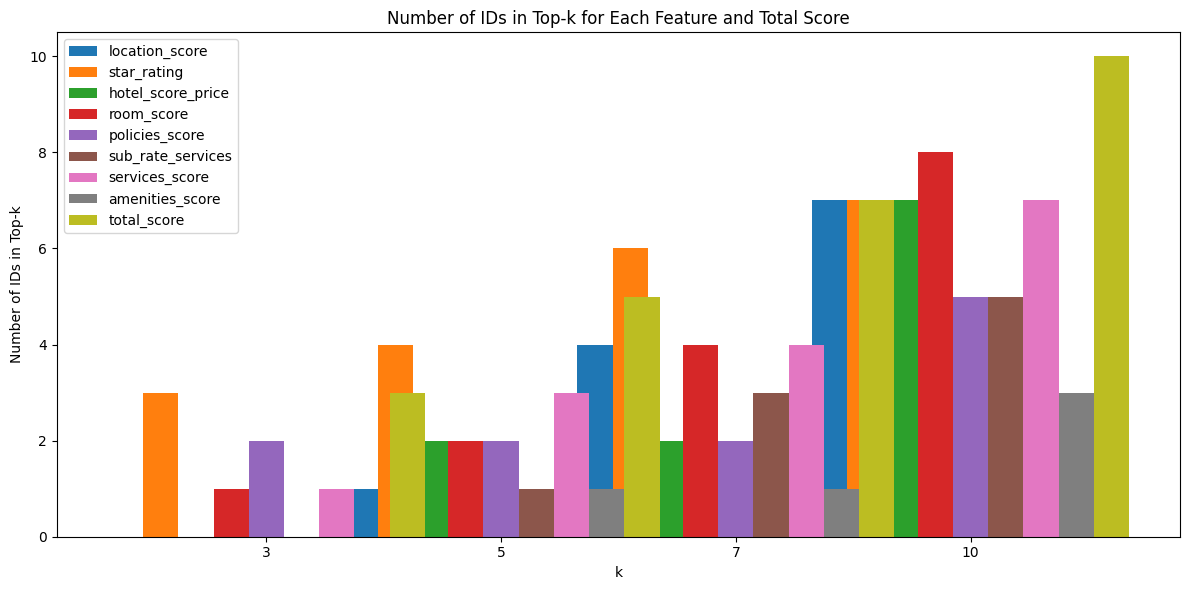

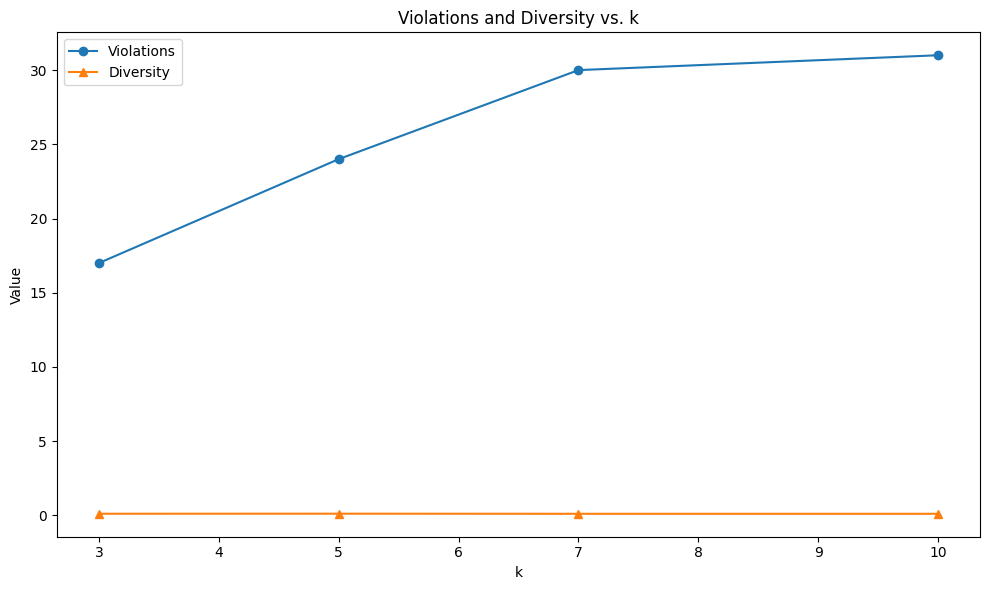

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hàm tính điểm tổng kết
def calculate_total_score(df, weights):
    """
    Tính điểm tổng kết dựa trên trọng số cho các cột trong DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số.
    - weights (list or np.array): Trọng số cho từng cột.

    Returns:
    - total_score (np.array): Điểm tổng kết cho từng hàng.
    """
    total_score = np.zeros(len(df))
    for i, col in enumerate(df.columns):
        total_score += weights[i] * df[col].values
    return total_score

# Hàm lấy top-k cho mỗi đặc trưng
def get_top_k_per_feature(df, k):
    """
    Lấy ít nhất k phần tử có giá trị cao nhất cho mỗi cột trong DataFrame,
    bao gồm tất cả các phần tử có giá trị bằng với phần tử thứ k.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số.
    - k (int): Số lượng phần tử tối thiểu muốn lấy.

    Returns:
    - top_k_dict (dict): Từ điển với key là tên cột, value là tập hợp các chỉ số của ít nhất k phần tử hàng đầu.
    """
    top_k_dict = {}
    for col in df.columns:
        values = df[col].values
        indices = np.arange(len(values))
        
        # Sắp xếp theo giá trị giảm dần
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = values[sorted_indices]
        
        # Xác định ngưỡng giá trị
        if len(sorted_values) >= k:
            threshold_value = sorted_values[k - 1]
        else:
            threshold_value = sorted_values[-1]
        
        # Lấy tất cả chỉ số có giá trị >= ngưỡng
        top_k_indices = indices[values >= threshold_value]
        top_k_dict[col] = set(top_k_indices)
    
    return top_k_dict

# Hàm đánh giá và đếm số lần xuất hiện trong top-k
def evaluate_results(df, weights, k_values):
    """
    Đánh giá kết quả với trọng số đã cho, đếm số lần xuất hiện trong top-k của mỗi đặc trưng và tổng điểm.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số.
    - weights (list or np.array): Trọng số cho từng cột.
    - k_values (list): Danh sách các giá trị k để xét top-k.

    Returns:
    - results (list): Danh sách kết quả cho từng k, bao gồm số vi phạm, độ đa dạng, và số lần xuất hiện trong top-k.
    """
    results = []
    
    # Tính điểm tổng kết
    total_score = calculate_total_score(df, weights)
    
    for k in k_values:
        # Lấy top-k dựa trên tổng điểm
        top_k_indices = np.argsort(total_score)[::-1][:k]
        top_k_ids = set(df.index[top_k_indices])
        top_k_df = df.iloc[top_k_indices]
        
        # Lấy top-k cho mỗi đặc trưng
        top_k_per_feature = get_top_k_per_feature(df, k)
        
        # Đếm số lần vi phạm (ID trong top-k tổng không nằm trong top-k đặc trưng)
        violations = 0
        for idx_id in top_k_indices:
            id_ = df.index[idx_id]
            for col in df.columns:
                if id_ not in df.index[list(top_k_per_feature[col])]:
                    violations += 1
        
        # Tính độ đa dạng (phương sai trung bình của các đặc trưng trong top-k)
        diversity = top_k_df.std().mean() if not top_k_df.empty else 0
        
        # Đếm số lần xuất hiện trong top-k của mỗi đặc trưng cho các ID trong top-k tổng
        top_k_counts = {col: [] for col in df.columns}
        top_k_counts['total_score'] = []
        for idx_id in top_k_indices:
            id_ = df.index[idx_id]
            top_k_counts['total_score'].append(id_)
            for col in df.columns:
                if id_ in df.index[list(top_k_per_feature[col])]:
                    top_k_counts[col].append(id_)
        
        results.append({
            'k': k,
            'violations': violations,
            'diversity': diversity,
            'top_k_counts': top_k_counts
        })
    
    return results

# Hàm trực quan hóa kết quả
def visualize_results(results, k_values, df_columns):
    """
    Trực quan hóa số lần vi phạm và độ đa dạng theo k.

    Parameters:
    - results (list): Kết quả từ evaluate_results.
    - k_values (list): Danh sách các giá trị k.
    - df_columns (list): Danh sách tên cột của DataFrame.
    """
    violations = [r['violations'] for r in results]
    diversities = [r['diversity'] for r in results]
    
    # Biểu đồ cột cho số lần xuất hiện trong top-k
    plt.figure(figsize=(12, 6))
    width = 0.15
    x = np.arange(len(k_values))
    for i, col in enumerate(df_columns + ['total_score']):
        counts = [len(r['top_k_counts'][col]) for r in results]
        plt.bar(x + i * width, counts, width, label=col)
    plt.xlabel('k')
    plt.ylabel('Number of IDs in Top-k')
    plt.title('Number of IDs in Top-k for Each Feature and Total Score')
    plt.xticks(x + width * (len(df_columns)) / 2, k_values)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Biểu đồ đường cho số lần vi phạm và độ đa dạng
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, violations, marker='o', label='Violations')
    plt.plot(k_values, diversities, marker='^', label='Diversity')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations and Diversity vs. k')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Hàm chuyển đổi scores thành DataFrame
def create_dataframe_from_scores(scores):
    """
    Chuyển đổi dictionary scores thành DataFrame với các cột là đặc trưng và chỉ số là ID.

    Parameters:
    - scores (dict): Dictionary chứa các dictionary điểm số cho từng đặc trưng.

    Returns:
    - df (pandas.DataFrame): DataFrame chứa điểm số.
    """
    # Lấy tất cả ID từ các dictionary
    all_ids = set()
    for score_dict in scores.values():
        all_ids.update(score_dict.keys())
    
    # Tạo DataFrame với các cột là đặc trưng
    df = pd.DataFrame(index=list(all_ids), columns=scores.keys())
    
    # Điền điểm số vào DataFrame
    for feature, score_dict in scores.items():
        for id_, score in score_dict.items():
            df.at[id_, feature] = score
    
    # Chuyển đổi sang kiểu số và điền NaN bằng 0 (nếu cần)
    df = df.astype(float).fillna(0)
    
    return df

# Tạo dictionary scores từ các kết quả đã tính
scores = {
    'location_score': score_location,
    'star_rating': score_star_rating,
    'hotel_score_price': score_price,
    'room_score': score_room,
    'policies_score': score_policies,
    'sub_rate_services': score_sub_rate_services,
    'services_score': score_services,
    'amenities_score': score_facilities,
    #'review_quality_score': score_quality_review,
    #'use_review_score': score_use_review
}
# Chuyển đổi scores thành DataFrame
df = create_dataframe_from_scores(scores)

# Trọng số đã cho (tổng bằng 1, ví dụ)
weights = np.array([0.15, 0.15, 0.15, 0.1, 0.1, 0.15, 0.1, 0.1])

# Các giá trị k để xét top-k
k_values = [3, 5, 7, 10]

# Đánh giá kết quả
results = evaluate_results(df, weights, k_values)

# In kết quả
for r in results:
    print(f"\nResults for k={r['k']}:")
    print(f"Violations: {r['violations']}")
    print(f"Diversity: {r['diversity']:.4f}")
    print("Top-k counts:")
    for feature, ids in r['top_k_counts'].items():
        print(f"  {feature}: {ids}")

# Trực quan hóa
visualize_results(results, k_values, df.columns.tolist())

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Hàm tính điểm tổng kết
def calculate_total_score(df, weights):
    """
    Tính điểm tổng kết dựa trên trọng số cho các cột trong DataFrame.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số, với các cột là đặc trưng và chỉ số là ID.
    - weights (list or np.array): Trọng số cho từng cột.

    Returns:
    - total_score (np.array): Điểm tổng kết cho từng hàng.
    """
    total_score = np.zeros(len(df))
    for i, col in enumerate(df.columns):
        total_score += weights[i] * df[col].values
    return total_score

# Hàm lấy top-k cho mỗi đặc trưng
def get_top_k_per_feature(df, k):
    """
    Lấy ít nhất k phần tử có giá trị cao nhất cho mỗi cột trong DataFrame,
    bao gồm tất cả các phần tử có giá trị bằng với phần tử thứ k.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số.
    - k (int): Số lượng phần tử tối thiểu muốn lấy.

    Returns:
    - top_k_dict (dict): Từ điển với key là tên cột, value là tập hợp các chỉ số của ít nhất k phần tử hàng đầu.
    """
    top_k_dict = {}
    for col in df.columns:
        values = df[col].values
        indices = np.arange(len(values))
        
        # Sắp xếp theo giá trị giảm dần
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = values[sorted_indices]
        
        # Xác định ngưỡng giá trị
        if len(sorted_values) >= k:
            threshold_value = sorted_values[k - 1]
        else:
            threshold_value = sorted_values[-1]
        
        # Lấy tất cả chỉ số có giá trị >= ngưỡng
        top_k_indices = indices[values >= threshold_value]
        top_k_dict[col] = set(top_k_indices)
    
    return top_k_dict

# Hàm đánh giá và đếm số lần xuất hiện trong top-k
def evaluate_results(df, weights, k_values):
    """
    Đánh giá kết quả với trọng số đã cho, đếm số lần xuất hiện trong top-k của mỗi đặc trưng và tổng điểm.

    Parameters:
    - df (pandas.DataFrame): DataFrame chứa điểm số.
    - weights (list or np.array): Trọng số cho từng cột.
    - k_values (list): Danh sách các giá trị k để xét top-k.

    Returns:
    - results (list): Danh sách kết quả cho từng k, bao gồm số vi phạm, độ đa dạng, và số lần xuất hiện trong top-k.
    """
    results = []
    
    # Tính điểm tổng kết
    total_score = calculate_total_score(df, weights)
    
    for k in k_values:
        # Lấy top-k dựa trên tổng điểm
        top_k_indices = np.argsort(total_score)[::-1][:k]
        top_k_ids = set(df.index[top_k_indices])
        top_k_df = df.iloc[top_k_indices]
        
        # Lấy top-k cho mỗi đặc trưng
        top_k_per_feature = get_top_k_per_feature(df, k)
        print(f"Top-k for k={k}: {top_k_indices}")
        
        # Đếm số lần vi phạm (ID trong top-k tổng không nằm trong top-k đặc trưng)
        violations = 0
        for idx_id in top_k_ids:
            id_ = df.index[idx_id]
            for col in df.columns:
                if id_ not in top_k_per_feature[col]:
                    violations += 1
        
        # Tính độ đa dạng (phương sai trung bình của các đặc trưng trong top-k)
        diversity = top_k_df.std().mean()
        
        # Đếm số lần xuất hiện trong top-k của mỗi đặc trưng cho các ID trong top-k tổng
        top_k_counts = {col: [] for col in df.columns}
        top_k_counts['total_score'] = []
        for idx_id in top_k_indices:
            id_ = df.index[idx_id]
            top_k_counts['total_score'].append(id_)
            for col in df.columns:
                if id_ in top_k_per_feature[col]:
                    top_k_counts[col].append(id_)
        
        results.append({
            'k': k,
            'violations': violations,
            'diversity': diversity,
            'top_k_counts': top_k_counts
        })
    
    return results

# Hàm trực quan hóa kết quả
def visualize_results(results, k_values, df_columns):
    """
    Trực quan hóa số lần vi phạm và độ đa dạng theo k counts.

    Parameters:
    - results (list): Kết quả từ evaluate_results.
    - k_values (list): Danh sách các giá trị k.
    - df_columns (list): Danh sách tên cột của DataFrame.
    """
    violations = [r['violations'] for r in results]
    diversities = [r['diversity'] for r in results]
    
    # Biểu đồ cột cho số lần xuất hiện trong top-k
    plt.figure(figsize=(12, 6))
    width = 0.15
    x = np.arange(len(k_values))
    for i, col in enumerate(df_columns + ['total_score']):
        counts = [len(r['top_k_counts'][col]) for r in results]
        plt.bar(x + i * width, counts, width, label=col)
    plt.xlabel('k')
    plt.ylabel('Number of IDs in Top-k')
    plt.title('Number of IDs in Top-k for Each Feature and Total Score')
    plt.xticks(x + width * (len(df_columns)) / 2, k_values)
    plt.legend()
    plt.show()
    
    # Biểu đồ đường cho số lần vi phạm và độ đa dạng
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, violations, marker='o', label='Violations')
    plt.plot(k_values, diversities, marker='^', label='Diversity')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations and Diversity vs. k')
    plt.legend()
    plt.show()



In [40]:
# Giả sử danh sách các dictionary
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    # 'score_review': score_review,
    # 'score_quality_review': score_quality_review,
    # 'result_final_review_score': result_final_review_score,
    # Thêm các score khác
}







In [64]:
df

,score_location,score_star_rating,score_room,score_price,score_policies,score_services,score_sub_rate_services,score_facilities
1666459,0.5561,1.0,0.8981,0.9961,0.5489,0.260420,0.940732,0.318615
13640787,0.1809,1.0,0.5098,0.2196,0.2364,0.000003,0.890244,0.706272
8189470,0.5575,1.0,0.8665,0.9329,0.3365,0.260420,0.831098,0.352182
4726272,0.4470,0.7,0.4000,0.1387,0.3225,0.846164,0.847317,0.748191
1763690,0.4374,0.7,0.8949,0.9898,0.5177,0.176059,0.930488,0.297508
1131852,0.1809,1.0,0.3101,0.0201,0.7733,0.176059,0.848659,0.287678
9432794,0.4874,1.0,0.8509,0.9132,0.2734,0.176059,0.941707,0.328959
2308922,0.4663,1.0,0.7661,0.9329,0.7579,0.796532,0.822073,0.321454
11323703,0.4600,1.0,0.8289,0.8578,0.5376,0.382656,0.953902,0.305468
6518787,0.4595,1.0,0.6010,0.4020,0.5052,0.000003,0.749146,0.719535


In [48]:
weights

array([0.15, 0.15, 0.15, 0.1 , 0.1 , 0.15, 0.1 , 0.1 ])

In [54]:
k_values = [10]

In [50]:
results = []

# Tính điểm tổng kết
total_score = calculate_total_score(df, weights)

In [55]:


for k in k_values:
    # Lấy top-k dựa trên tổng điểm
    top_k_indices = np.argsort(total_score)[::-1][:k]
    top_k_ids = set(df.index[top_k_indices])
    top_k_df = df.iloc[top_k_indices]
    
    # Lấy top-k cho mỗi đặc trưng
    top_k_per_feature = get_top_k_per_feature(df, k)
    print(f"Top-k for k={k}: {top_k_indices}")
    
    # Đếm số lần vi phạm (ID trong top-k tổng không nằm trong top-k đặc trưng)
    violations = 0
    for idx_id in top_k_indices:
        id_ = df.index[idx_id]
        for col in df.columns:
            if id_ not in top_k_per_feature[col]:
                violations += 1
    
    # Tính độ đa dạng (phương sai trung bình của các đặc trưng trong top-k)
    diversity = top_k_df.std().mean()
    
    # Đếm số lần xuất hiện trong top-k của mỗi đặc trưng cho các ID trong top-k tổng
    top_k_counts = {col: [] for col in df.columns}
    top_k_counts['total_score'] = []
    for idx_id in top_k_indices:
        id_ = df.index[idx_id]
        top_k_counts['total_score'].append(id_)
        for col in df.columns:
            if id_ in top_k_per_feature[col]:
                top_k_counts[col].append(id_)
    
    results.append({
        'k': k,
        'violations': violations,
        'diversity': diversity,
        'top_k_counts': top_k_counts
    })


Top-k for k=10: [ 7 16 11 12  0  8  2 20 18  6]


In [63]:
idx_id

6

In [61]:
top_k_indices

array([ 7, 16, 11, 12,  0,  8,  2, 20, 18,  6], dtype=int64)

In [59]:
top_k_ids

{'11323703',
 '11954981',
 '1666459',
 '2278497',
 '2308922',
 '3088081',
 '3153554',
 '3189136',
 '8189470',
 '9432794'}

In [57]:
top_k_df

,score_location,score_star_rating,score_room,score_price,score_policies,score_services,score_sub_rate_services,score_facilities
2308922,0.4663,1.0,0.7661,0.9329,0.7579,0.796532,0.822073,0.321454
3189136,0.5282,1.0,0.8825,0.9898,0.7852,0.176059,0.855244,0.707022
11954981,0.4600,1.0,0.8664,0.9328,0.4578,0.691451,0.897927,0.322801
3088081,0.5282,0.7,0.8665,0.9329,0.4643,0.796532,0.872927,0.346667
1666459,0.5561,1.0,0.8981,0.9961,0.5489,0.260420,0.940732,0.318615
11323703,0.4600,1.0,0.8289,0.8578,0.5376,0.382656,0.953902,0.305468
8189470,0.5575,1.0,0.8665,0.9329,0.3365,0.260420,0.831098,0.352182
3153554,0.5408,0.7,0.8650,0.9902,0.5742,0.309920,0.879024,0.333595
2278497,0.5408,0.7,0.8798,0.9961,0.7496,0.176059,0.782561,0.320758
9432794,0.4874,1.0,0.8509,0.9132,0.2734,0.176059,0.941707,0.328959


In [60]:
top_k_per_feature

{'score_location': {0, 2, 6, 10, 12, 14, 16, 18, 20, 21},
 'score_star_rating': {0,
  1,
  2,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  13,
  14,
  15,
  16,
  17,
  21,
  22,
  23},
 'score_room': {0, 2, 4, 6, 10, 11, 12, 16, 18, 20},
 'score_price': {0, 2, 4, 7, 10, 12, 16, 18, 20, 22},
 'score_policies': {0, 5, 7, 14, 16, 18, 19, 20, 22, 24},
 'score_services': {0, 2, 3, 7, 8, 11, 12, 20, 21, 22},
 'score_sub_rate_services': {0, 1, 4, 6, 8, 11, 15, 19, 20, 23},
 'score_facilities': {1, 2, 3, 9, 12, 14, 16, 19, 21, 23}}

Top-k for k=10: [ 7 16 11 12  0  8  2 20 18  6]
Top-k for k=25: [ 7 16 11 12  0  8  2 20 18  6 10  4 14 22 21  3  9 19 13 17  1 24  5 23
 15]

Results for k=10:
Violations: 80
Diversity: 0.1097
Top-k counts:
  score_location: []
  score_star_rating: []
  score_room: []
  score_price: []
  score_policies: []
  score_services: []
  score_sub_rate_services: []
  score_facilities: []
  total_score: ['2308922', '3189136', '11954981', '3088081', '1666459', '11323703', '8189470', '3153554', '2278497', '9432794']

Results for k=25:
Violations: 200
Diversity: 0.1944
Top-k counts:
  score_location: []
  score_star_rating: []
  score_room: []
  score_price: []
  score_policies: []
  score_services: []
  score_sub_rate_services: []
  score_facilities: []
  total_score: ['2308922', '3189136', '11954981', '3088081', '1666459', '11323703', '8189470', '3153554', '2278497', '9432794', '11510359', '1763690', '4252408', '4347923', '1892845', '4726272', '6518787', '4578805', '11580646', '11054837', '13640

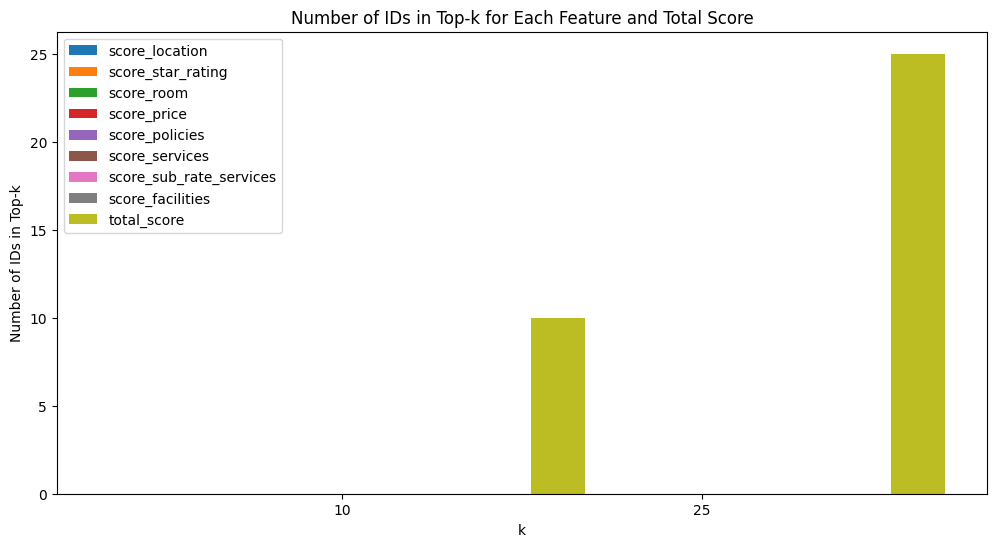

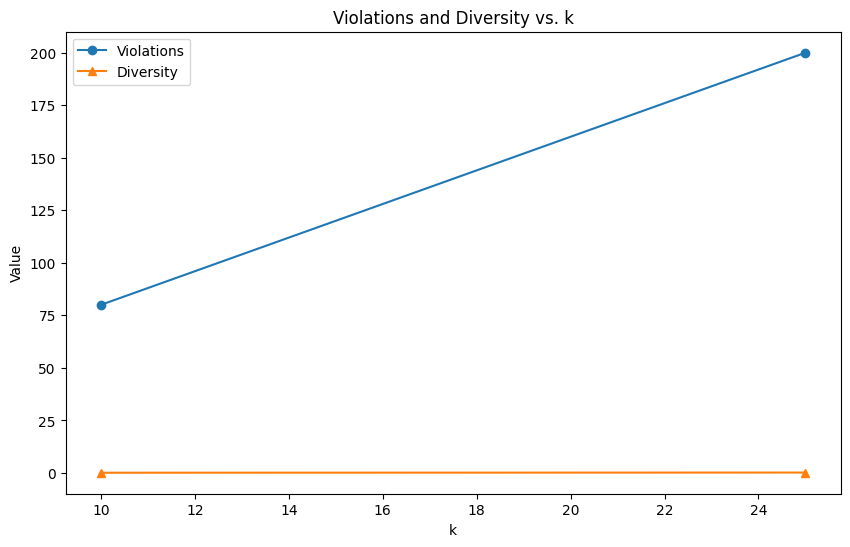

In [44]:
# Chuyển đổi scores thành DataFrame
common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


# Trọng số đã cho (tổng bằng 1, ví dụ)
weights = np.array([0.15, 0.15, 0.15, 0.1, 0.1, 0.15, 0.1, 0.1])

# Các giá trị k để xét top-k
k_values = [10, 25]

# Đánh giá kết quả
results = evaluate_results(df, weights, k_values)

# In kết quả
for r in results:
    print(f"\nResults for k={r['k']}:")
    print(f"Violations: {r['violations']}")
    print(f"Diversity: {r['diversity']:.4f}")
    print("Top-k counts:")
    for feature, ids in r['top_k_counts'].items():
        print(f"  {feature}: {ids}")

# Trực quan hóa
visualize_results(results, k_values, df.columns.tolist())